<a href="https://colab.research.google.com/github/swishswish123/tracked_surgery_simulations/blob/main/tracked_pointer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) TRACKED POINTER SIMULATION

The current state of the art for pituitary surgery uses a tracked pointer, registered to a pre-operative MR scan for orientation of surrounding anatomy. This notebook explores what the expected level of accuracy might be.

## imports and utility functions

In [1]:
# github repo which contains all the images
!git clone https://github.com/swishswish123/tracked_surgery_simulations.git repo

Cloning into 'repo'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 80 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (80/80), 2.63 MiB | 2.05 MiB/s, done.


In [2]:
# install necessary packages
!pip install scikit-surgerycore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surgerycore: filename=scikit_surgerycore-0.6.10-py2.py3-none-any.whl size=23594 sha256=5759cddf3febcbd49579a2a31ed9ca9a6bf07d59d3a27bb4a0b4358b515fe307
  Stored in directory: /root/.cache/pip/wheels/9c/41/e0/a9243058cb461a809cd19756422265b39cfc3c67b73589ad53
Successfully built scikit-surgerycore


In [3]:
# importing packages
from IPython.display import Image
import numpy as np
import sksurgerycore.transforms.matrix as stm
import sksurgerycore.transforms.matrix as mu
import cv2
import math
import sksurgerycore.algorithms.procrustes as pro
from scipy.spatial.transform import Rotation as spr
import copy
import random
import matplotlib.pyplot as plt

In [4]:

def extrinsic_matrix_to_vecs(matrix):
    """
    extract_rigid_body_parameters(matrix)
    extracts parameters from transformation matrix

    Args:
        matrix: 4x4 transformation matrix

    Returns:
        list of rigid body parameters [tx, ty, tz, rx, ry, rz]

    """
    t = matrix[0:3, 3]
    r = matrix[0:3, 0:3]
    rot = spr.from_matrix(r)
    euler = rot.as_euler('xyz', degrees=True)
    return [t[0], t[1], t[2], euler[0], euler[1], euler[2]]

def extrinsic_vecs_to_matrix(params):
    """
    rigid_body_parameters_to_matrix(params)
    converts a list of rigid body parameters to transformation matrix

    Args:
        params: list of rigid body parameters [tx, ty, tz, rx, ry, rz]

    Returns:
        4x4 transformation matrix of these parameters

    """
    matrix = np.eye(4)
    
    matrix[0][3] = params[0]
    matrix[1][3] = params[1]
    matrix[2][3] = params[2]

    r = (spr.from_euler('xyz', [params[3], params[4], params[5]], degrees=True)).as_matrix()
    matrix[0:3, 0:3] = r
    return matrix



In [5]:
def multiply_points_by_matrix(matrix_4x4, matrix_of_points, do_transpose):
    """
    Multiplies all points by the same matrix.

    :param matrix_4x4: Numpy ndarray, 4x4, containing homogenous, rigid transformation
    :param matrix_of_points: Numpy ndarray, 4xN, containing N points as 4D homogeneous column vectors.
    :param do_transpose: if true, we also transpose
    """
    input_matrix = matrix_of_points

    if do_transpose:
        input_matrix = np.transpose(matrix_of_points)

    result = np.matmul(matrix_4x4, input_matrix)

    if do_transpose:
        result = np.transpose(result)

    return result

def multiply_points_by_transform(D3_hom, T):
    """
    Applies a 4x4 transformation matrix to a set of 3D points.

    Args:
        D3_points (numpy.ndarray): Array of 3D points with shape (N, 3).
        T (numpy.ndarray): 4x4 transformation matrix.

    Returns:
        (numpy.ndarray) Array of transformed 3D points with shape (N, 3).
    """
    #D3_hom = cv2.convertPointsToHomogeneous(D3_points).squeeze()
    D3_transformed_points_hom = T @ D3_hom.T
    #D3_transformed_points_hom = D3_transformed_points_hom.reshape(4, -1)
    #D3_transformed = cv2.convertPointsFromHomogeneous(D3_transformed_points_hom.T).squeeze()

    return D3_transformed_points_hom.T

## Background, System Layout, goal and assumptions

The following diagram shows the layout of the navigation system and the different components involved in the surgery when using a pointer. 

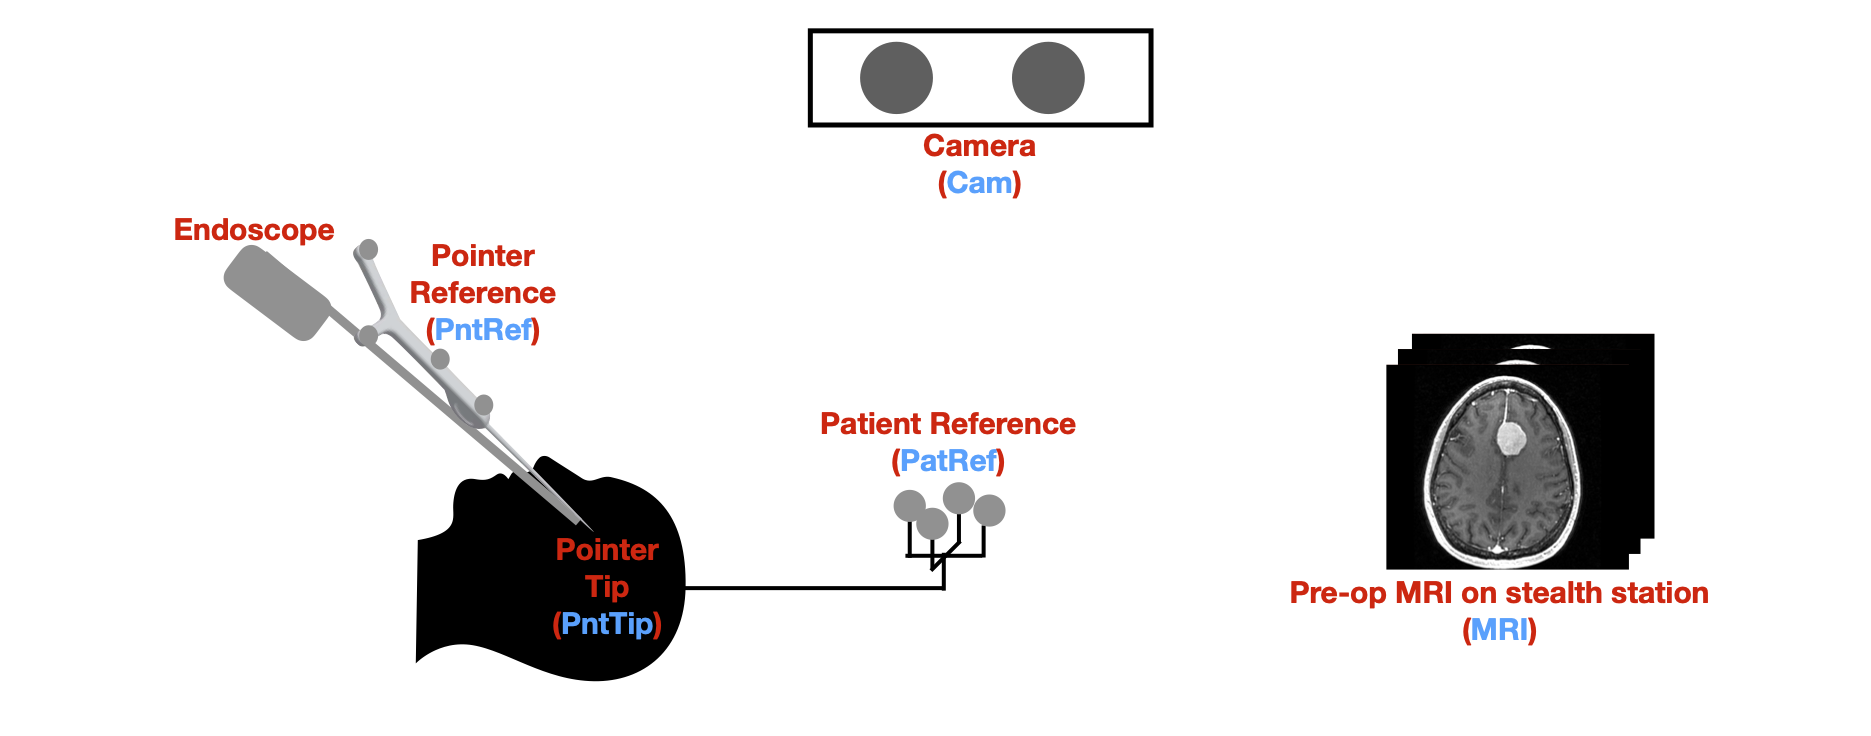

In [6]:
Image(filename="./repo/assets/pointer_setup.png")



### A bit of maths background:
To convert between different coordinate systems, we can use a mathematical transform, defined as ${}^{B}T_{A}$. This maps a point from the coordinate system $A$ to the coordinate system $B$. 

${}^{B}T_{A}$ can be defined as a (4x4) matrix. Since we assume the transformations to be rigid, this matrix can only be composed of rotations and translations.

${}^{B}T_{A} = 
\begin{bmatrix}
R & T \\
0 & 1
\end{bmatrix}$

Where R is a (3x3) sub-matrix of ${}^{B}T_{A}$, represents the rotation component of the transform. It defines how the axes of the $A$ coordinate system should be rotated to align with the axes of the $B$ coordinate system. The translation component, denoted as $T$ (3x1), represents the offset between the origins of the $A$ and $B$ coordinate systems.

Now by applying ${}^{B}T_{A}$ to a point in the $A$ coordinate system, we can transform the point to its corresponding position in the $B$ coordinate system. 

### Combining transforms
Different transforms can be combined to create a transform from one coordinate system to another. Suppose we have three coordinate systems, $A$, $B$, and $C$. We have transformations ${}^{B}T_{A}$ which map points from coordinate system $A$ to $B$ and ${}^{C}T_{B}$ which maps from $B$ to $C$. We can use these transformations to create a transform ${}^{C}T_{A}$, which maps points from coordinate system $A$ to $C$. This composed transform can be obtained by simply multiplying the other two in the correct order:

${}^{C}T_{A}$ = ${}^{C}T_{B}$ · ${}^{B}T_{A}$

Note that the combination starts on the right and ends on the left- we start at coordinate system $A$ and convert it to $B$ with ${}^{B}T_{A}$ on the right and then we move towards the left converting $B$ to $C$- ${}^{C}T_{B}$.

${}^{C}T_{A}$ can now be used to convert any point from coordinate system $A$ to coordinate system $C$.



### Goal

Going back to our problem, the goal is to be able to match the coordinate system of the pointer's tip to the MRI so that wherever we put the pointer's tip, this location can be displayed on the MRI.

What we want to achieve is obtain a transform
from the pointer's tip to the MRI coordinate system.

X<sub>MRI</sub> = T X<sub>PntTip</sub>

We cannot obtain a direct transformation with our setup, but we can build this transformation out of the following transformations:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>PntTip</sub>

Note on notation used:
As in the diagram, Pnt stands for pointer, Ref stands for reference, Cam stands for the infrared camera and Pat stands for patient. 

In the following sections we will go step by step composing these transforms and finally using them to transform a point from pointer tip (PntTip) coordinates to MRI coordinates.

Below is a visual representation of the pointer setup with all the transforms:


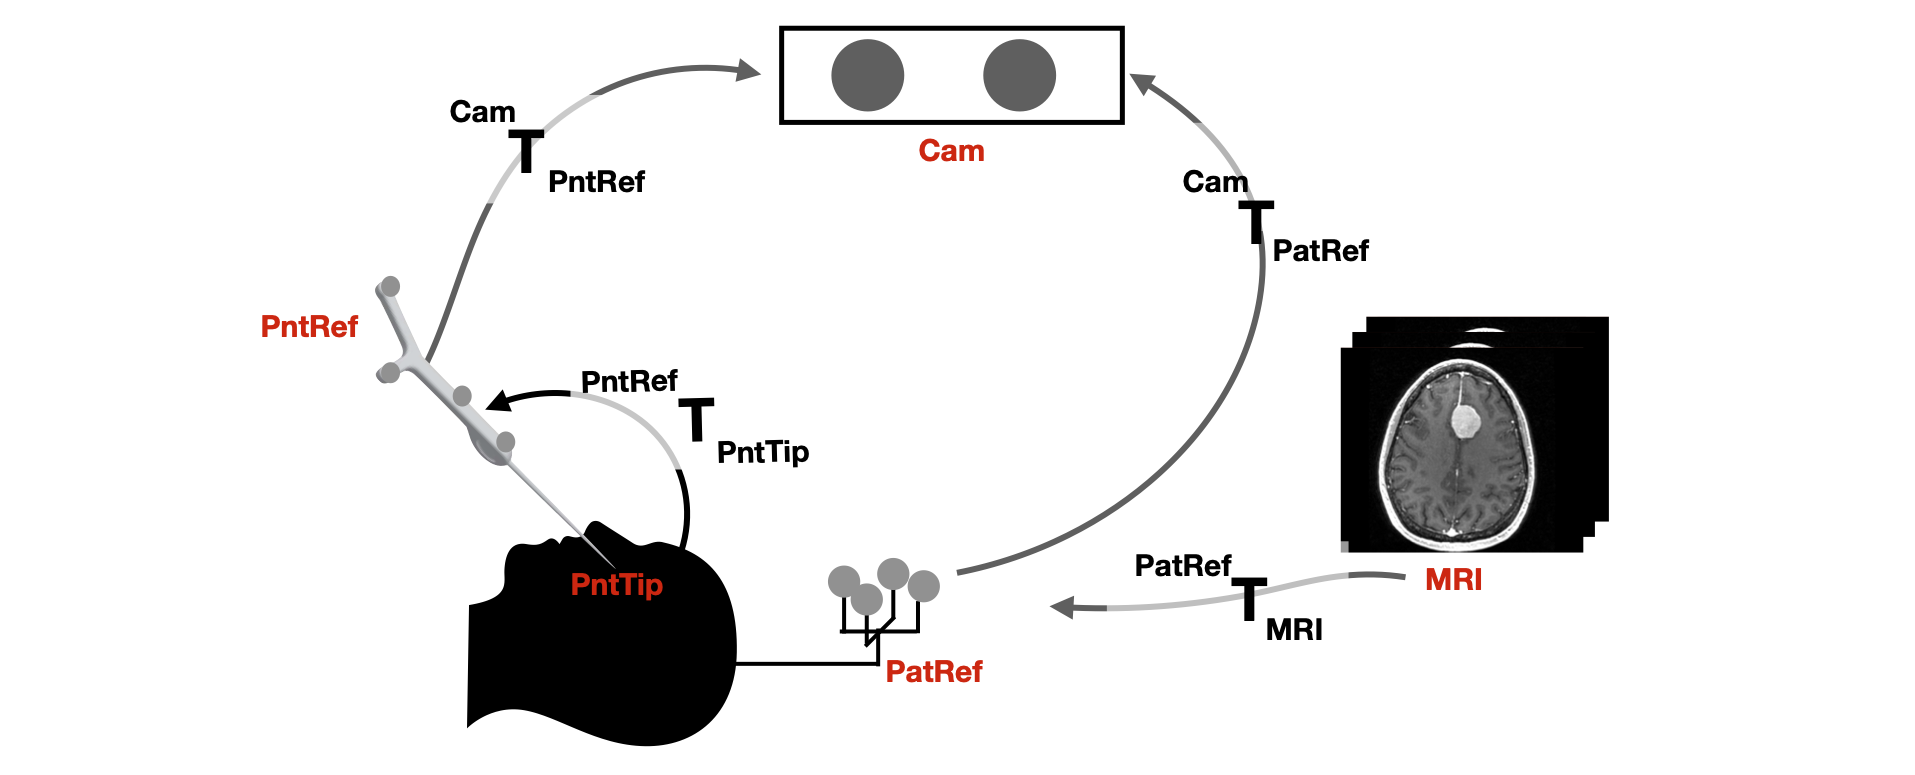

In [7]:
Image(filename="./repo/assets/pointer_setup_transforms.png")

### Assumptions

1. tumour, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is $D$.

2. Patient reference is at a set distance $Y_t$ from the tumour but aligned in the X direction.

3. Pointer is touching the tumour, so the pointer and tumour have the same coordinates.

4. Length of pointer is known ($P$)

5. Angle of pointer is known ($𝜃$)

6. All transformations assumed to be rigid

Below is a visual representation of the sagittal and transverse views with all assumptions.


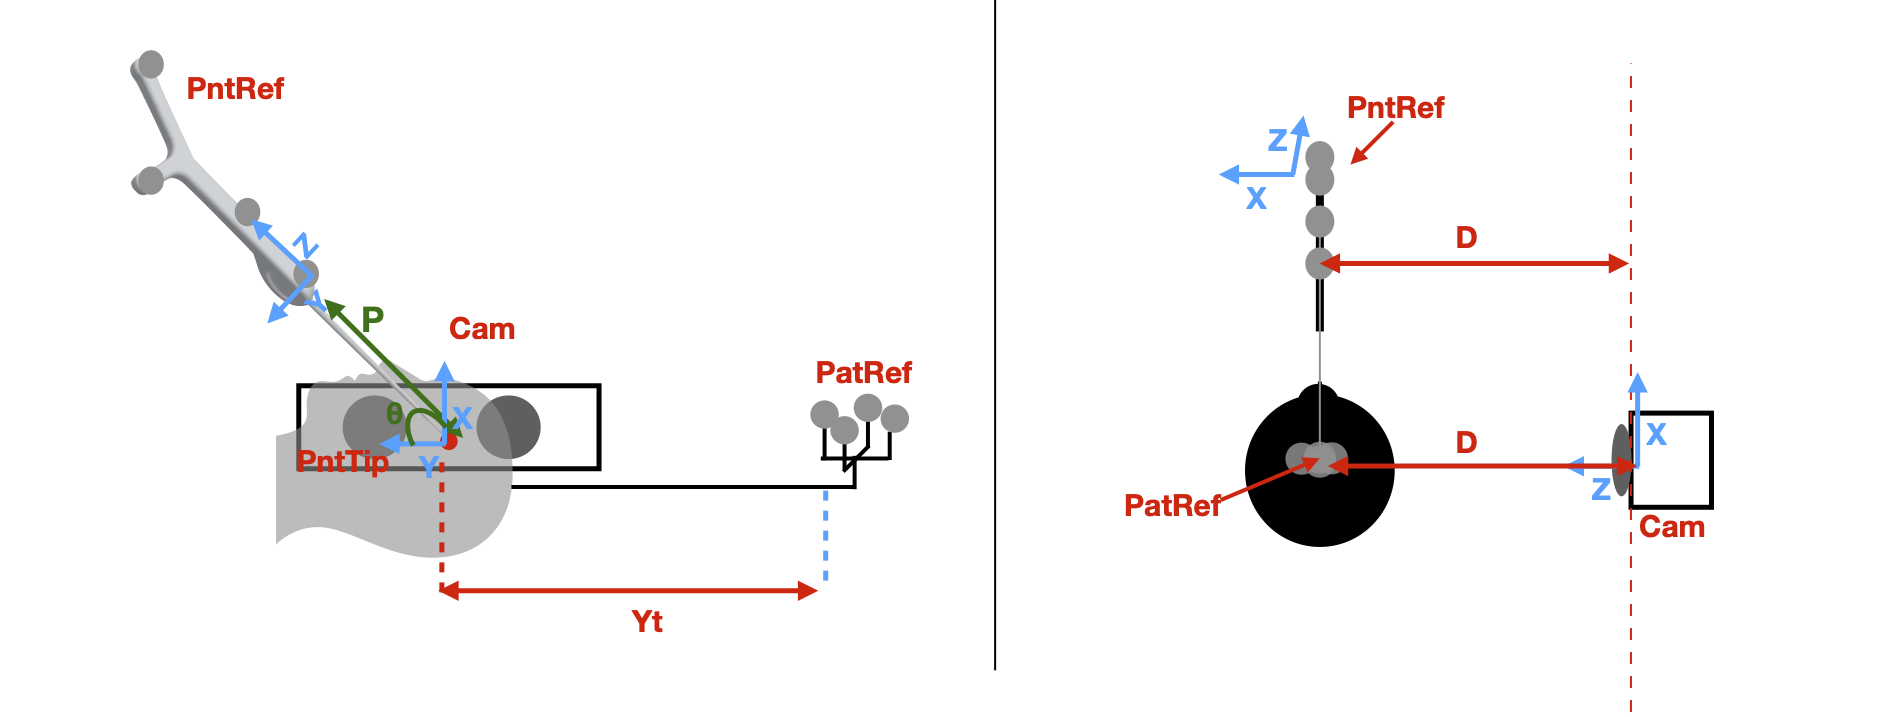

In [8]:
Image(filename="./repo/assets/pointer_setup_assumptions.png")

In [9]:
# Assumptions- configurable parameters

# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
POINTER_LENGTH = 160  

# D - z distance from camera to plane where everything is located
DISTANCE_FROM_CAM = 2000  # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 𝜃 - angle of pointer
POINTER_ANGLE = 45

# Yt - distances from tumour to patient reference
TUMOUR_PARTEF = 300

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
# TYPICAL_TRACKING_SIGMA = 0.25

# for simulation reproducibility
NUMBER_SAMPLES = 100

# for sufrace registration initial misalignment
X_T = 100  # head length (about 20cm)
Y_T = 130  # menton to top of head (about 25cm)
Z_T = 80  # head bredth (about 15cm)

END_SIGMA = 0.5
SIGMA_STEP = 0.01


## Defining some functions

In order to obtain the transforms, we also need to define the reference of the different coordinate systems.

A reference is essentially a unique grouping of reflective markers, attached to a tool which defines a local coordinate system. The markers' location can be determined as they are reflective and therefore the infrared camera can locate them in space at any given point if they are within the camera's working range.

Below you can see the reference systems used for the patient and the pointer:

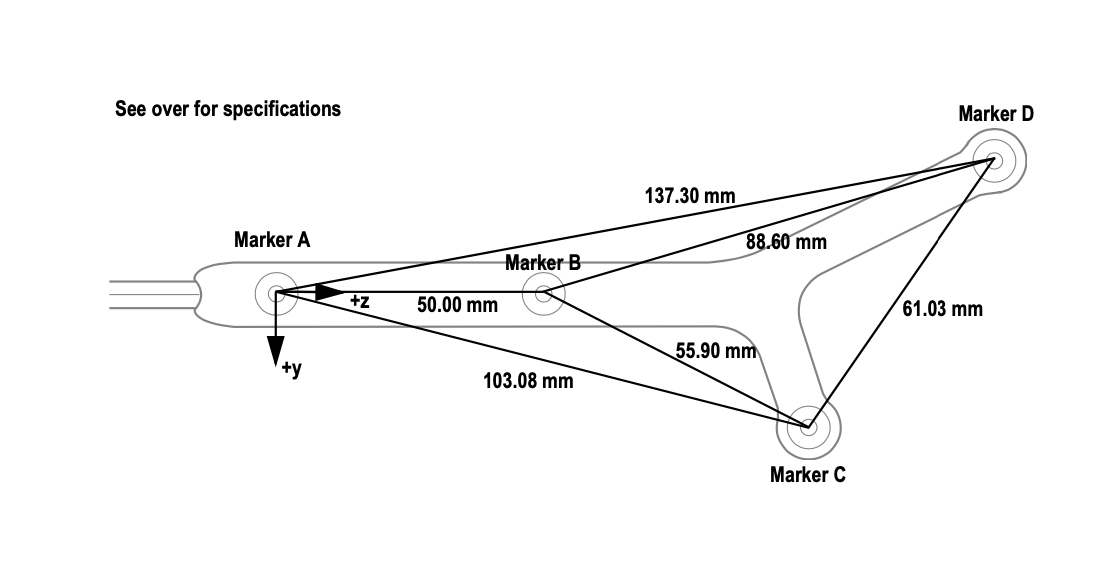

In [10]:
# pointer reference
Image('./repo/assets/pointref_geometry.png')


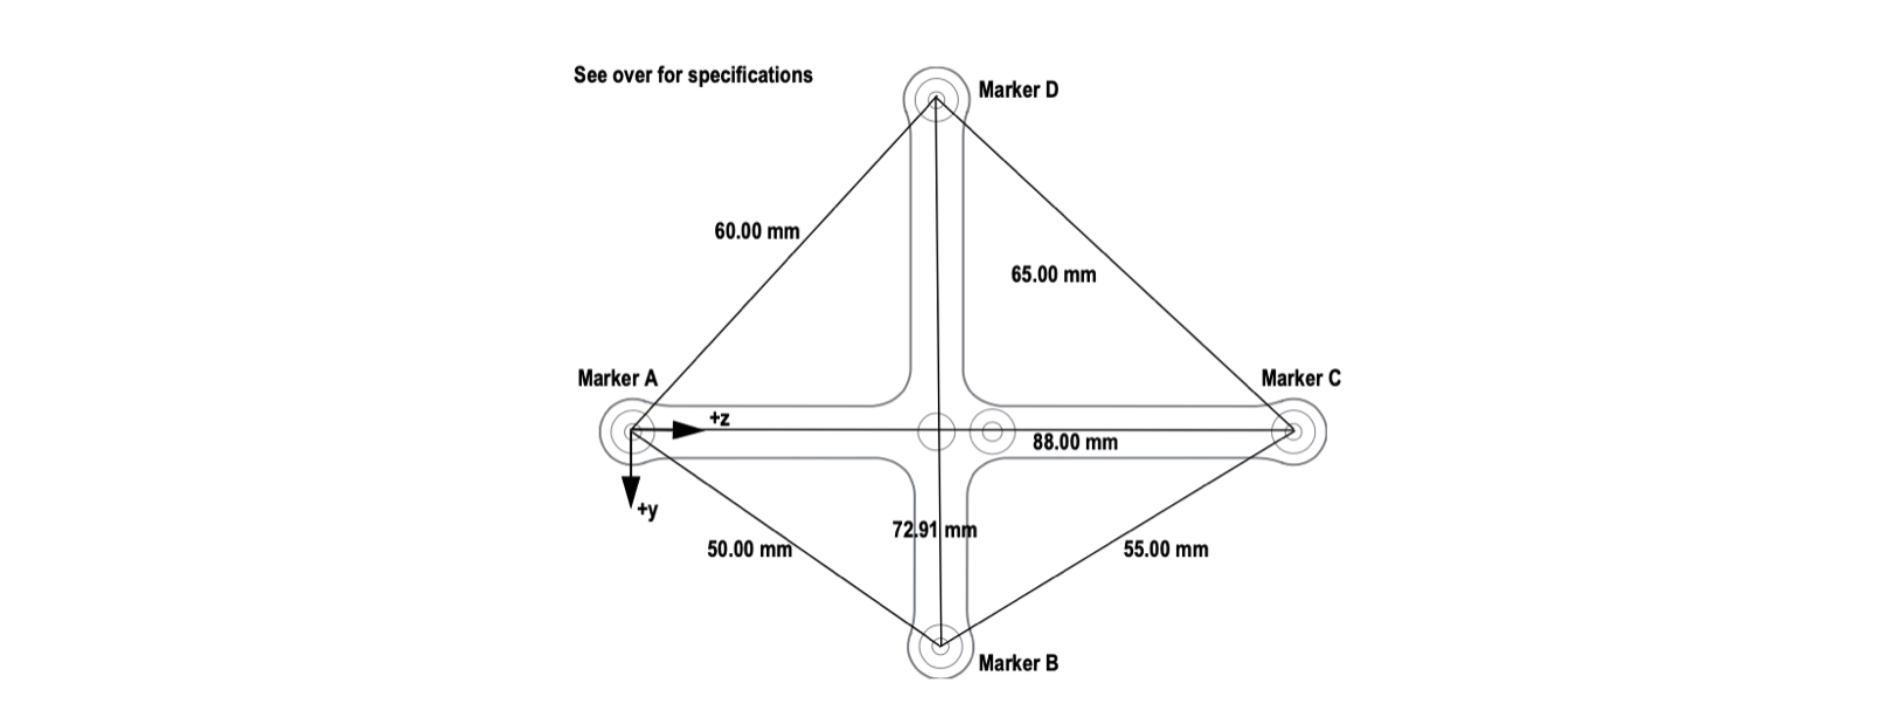

In [11]:
# patient reference
Image('./repo/assets/patref_geometry.png')


In [12]:

def create_pat_ref():
    """
    Create reference coordinates of a marker pattern in a numpy matrix.

    This function creates a numpy matrix containing the reference coordinates of a marker pattern used for
    pose estimation. The marker pattern consists of four markers labeled A, B, C and D. The reference coordinates
    of each marker point are defined in a right-handed reference frame as follows:

        Marker A: (0, 0, 0)
        Marker B: (41.02, 0, 28.59)
        Marker C: (88.00, 0, 0)
        Marker D: (40.45, 0, -44.32)

    The function returns a 4x4 numpy matrix containing the homogenous coordinates of each marker point, with the
    last element of each row set to 1.

    Returns:
        numpy.ndarray: A 4x4 numpy matrix containing reference coordinates of a marker pattern. Each row represents a
        marker point in homogenous coordinates.
    """

    # Encoding the reference marker points into a numpy matrix
    pat_ref = np.zeros((4, 4))
    # marker A (0) -> (0,0,0)

    # marker B (1) -> (41.02 ,0,28.59)
    pat_ref[1][0] = 41.02  # x
    pat_ref[1][2] = 28.59  # z

    # marker C (2) -> C = (88.00 ,0, 0)
    pat_ref[2][0] = 88  # x

    # marker D (3) -> (40.45,0,-44.32)
    pat_ref[3][0] = 40.45  # x
    pat_ref[3][2] = -44.32  # z

    # adding 1 to last row to make coordinates homogenous
    pat_ref[0][3] = 1.0
    pat_ref[1][3] = 1.0
    pat_ref[2][3] = 1.0
    pat_ref[3][3] = 1.0
    return pat_ref


def create_pnt_ref():
    """
    Creates a numpy matrix representing the pointer reference coordinates.

    Returns:
    pnt_ref (numpy matrix): A 4x4 numpy matrix containing the pointer reference coordinates
                            as row vectors in homogenous coordinates. The four rows represent
                            the markers A, B, C, and D in that order.
    """
    # Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
    pnt_ref = np.zeros((4, 4))

    # marker A (0) -> 0,0,0

    # marker B (1) -> 0,50,0
    pnt_ref[1][1] = 50  # y

    # marker c (2) -> 25,100,0
    pnt_ref[2][0] = 25  # x
    pnt_ref[2][1] = 100  # y

    # marker d (3) -> -25, 135, 0
    pnt_ref[3][0] = -25  # x
    pnt_ref[3][1] = 135  # y

    # adding 1 to 3rd dimension to turn to homogeneous coordinates
    pnt_ref[0][3] = 1
    pnt_ref[1][3] = 1
    pnt_ref[2][3] = 1
    pnt_ref[3][3] = 1

    return pnt_ref



# Obtaining transforms

Sine we are assuming the layout and relative positions of each reference marker, we are able to obtain the transformations between each coordinate system.

Let's run through the simplest example- 
${}^{PntRef}T_{PntTip}$, which is the first transform we want to perform on a point in pointer tip coordinates.

The only difference between the pointer tip and the pointer reference is a translation along the y direction of the pointer tip coordinate system. The value of this translation in y is the pointer's length. Note that it is a negative translation as the coordinate is now on the first marker of the reference instead of the tip.

However, in our case we will initially have our values in pointer reference since the camera is tracking the markers and not the pointer tip. Therefore, we can obtain the transform ${}^{PntTip}T_{PntRef}$. This is not a problem because we can then invert this transform to obtain the transform we want:

${}^{PntRef}T_{PntTip}$ = (${}^{PntTip}T_{PntRef}$)$^{-1}$

A visual representation can be seen in the below diagram:

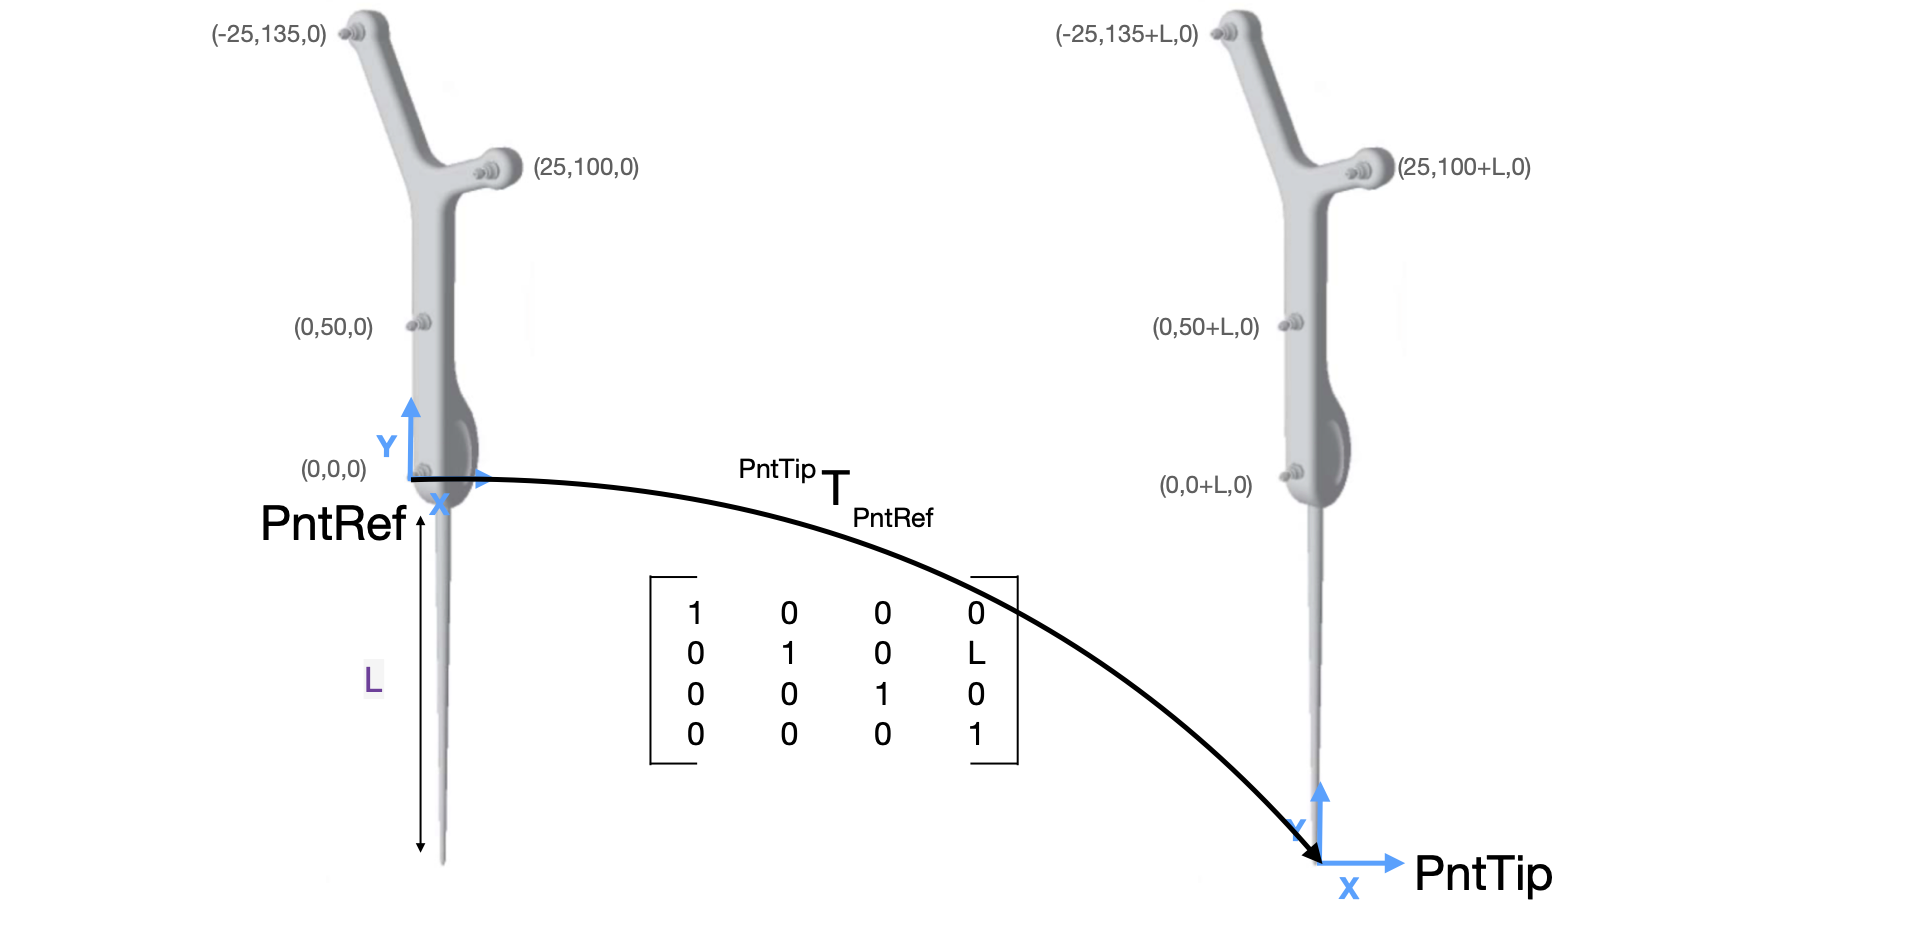

In [13]:
Image('./repo/assets/pntRef_pntTip_transform.png')

So first let's obtain ${}^{PntTip}T_{PntRef}$:

In [14]:
# pointer reference in pointer reference coordinate system
pnt_ref_marker = create_pnt_ref()  # marker coords

# constructing the transformation matrix PntRef_T_PntTip with a translation in the y direction of -L
PntTip_T_PntRef = extrinsic_vecs_to_matrix(
        [0, POINTER_LENGTH, 0, 0, 0, 0])

print('PntTip_T_PntRef')
print(PntTip_T_PntRef)

PntTip_T_PntRef
[[  1.   0.   0.   0.]
 [  0.   1.   0. 160.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


and now invert it to get ${}^{PntRef}T_{PntTip}$ :

In [15]:
PntRef_T_PntTip = np.linalg.inv(PntTip_T_PntRef)
print('PntRef_T_PntTip')
print(PntRef_T_PntTip)

PntRef_T_PntTip
[[   1.    0.    0.    0.]
 [   0.    1.    0. -160.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]


Now you can see that if we transform a point from the pointer tip coordinate system it will move by -L in the y direction. Note that coordinates are represented as homogenous coordinates to allow us to multiply by the 4x4 transform. (This basically means the coordinates are represented as [x,y,z,1]

In [16]:
# transforming the point [0,0,0] by PntRef_T_PntTip
pnt_ref_tip = multiply_points_by_transform(np.array([0,0,0,1]), PntRef_T_PntTip)
print(pnt_ref_tip)

[   0. -160.    0.    1.]


We can also convert all the markers on the pointer reference to be represented in the pointer's tip coordinate system:

In [17]:
print('original pointer reference in pointer ref coordinate system:')
print(pnt_ref_marker)

# convert to pointer tip coordinate system:
pnt_ref_tip = multiply_points_by_transform(pnt_ref_marker, PntRef_T_PntTip)
print('pointer reference in pointer tip coordinate system:')
print(pnt_ref_tip)

original pointer reference in pointer ref coordinate system:
[[  0.   0.   0.   1.]
 [  0.  50.   0.   1.]
 [ 25. 100.   0.   1.]
 [-25. 135.   0.   1.]]
pointer reference in pointer tip coordinate system:
[[   0. -160.    0.    1.]
 [   0. -110.    0.    1.]
 [  25.  -60.    0.    1.]
 [ -25.  -25.    0.    1.]]


We perform a similar analysis to obtain the rest of the transforms. The function below generates these transformations with the given pointer length and the parameters defined in the assumptions section.

Remember we want at the end a composition of all these transforms:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>PntTip</sub>

In [18]:
def get_transforms(pointer_length=100, POINTER_ANGLE=45,DISTANCE_FROM_CAM=2000, TUMOUR_PARTEF=40  ):
    """
    Returns a set of coordinate transformation matrices that convert points from one reference frame to another.

    Args:
        pointer_length (float): Length of the pointer in millimeters. Default is 100.
        POINTER_ANGLE (float): z angle at which pointer is angled
        DISTANCE_FROM_CAM (float): distance from camera to patient
        TUMOUR_PARTEF (float): distance from tumour to patient reference

    Returns:
        tuple: A tuple containing the following eight transformation matrices:
        - PatRef_T_MRI: A 4x4 transformation matrix that converts points from the MRI reference frame to the patient reference frame.
        - PatRef_T_Cam: A 4x4 transformation matrix that converts points from the camera reference frame to the patient reference frame.
        - Cam_T_PntRef: A 4x4 transformation matrix that converts points from the pointer reference frame to the camera reference frame.
        - PntRef_T_PntTip: A 4x4 transformation matrix that converts points from the pointer tip reference frame to the pointer reference frame.

        and the following numpy arrays containing the homogenous coordinates of the points in the given reference frame
        - pnt_ref_marker:  in the pointer reference frame.
        - pnt_ref_cam: in the camera reference frame.
        - pat_ref_marker: in the patient reference frame.
        - pat_ref_cam: in the camera reference frame.

    """

    # 1) obtaining PntRef_T_PntTip
    print(f'pointer length: {pointer_length}')
    # Creating pointer reference in the pointer reference frame.
    pnt_ref_marker = create_pnt_ref()  # marker coords
    # Point reference to point tip: (pointer length translation in y)
    PntTip_T_PntRef = extrinsic_vecs_to_matrix(
        [0, pointer_length, 0, 0, 0, 0]) # create transform of all points depending on pointer's length
    # invert to get tip to ref:
    PntRef_T_PntTip = np.linalg.inv(PntTip_T_PntRef)

    # 2) obtaining Cam_T_PntRef
    # Converting the marker points to the camera reference frame by applying a
    # rotation of POINTER_ANGLE degrees about the z-axis followed by a
    # translation of DISTANCE_FROM_CAM along the z-axis of camera.
    rotate_about_z = extrinsic_vecs_to_matrix([0, 0, 0, 0, 0, POINTER_ANGLE])
    translate_away_from_camera = extrinsic_vecs_to_matrix([0, 0, DISTANCE_FROM_CAM, 0, 0, 0])
    Cam_T_PntRef = translate_away_from_camera @ rotate_about_z
    pnt_ref_cam = multiply_points_by_transform(pnt_ref_marker, Cam_T_PntRef)

    # 3) obtaining Cam_T_PatRef
    # PatRef to Cam (add dist to cam to z plus x translation to right)
    pat_ref_marker = create_pat_ref()
    # translating to correct location 
    translate_along_x = extrinsic_vecs_to_matrix([TUMOUR_PARTEF, 0, 0, 0, 0, 0])
    Cam_T_PatRef = translate_along_x @ translate_away_from_camera
    pat_ref_cam = multiply_points_by_transform(pat_ref_marker, Cam_T_PatRef)
    PatRef_T_Cam = np.linalg.inv(Cam_T_PatRef)

    # 4) obtaining PatRef_T_MRI
    PatRef_T_MRI = extrinsic_vecs_to_matrix([X_T, Y_T, Z_T, 0, 0, 0])
    MRI_T_PatRef = np.linalg.inv(PatRef_T_MRI)

    return MRI_T_PatRef, PatRef_T_Cam, Cam_T_PntRef, PntRef_T_PntTip, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam


In [19]:
MRI_T_PatRef, PatRef_T_Cam, Cam_T_PntRef, PntRef_T_PntTip, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam = get_transforms(pointer_length=POINTER_LENGTH, POINTER_ANGLE=POINTER_ANGLE,DISTANCE_FROM_CAM=DISTANCE_FROM_CAM, TUMOUR_PARTEF=TUMOUR_PARTEF)

pointer length: 160


In [20]:
print('our 4 transforms:')

print('PatRef_T_MRI')
print(MRI_T_PatRef)

print('Cam_T_PatRef')
print(PatRef_T_Cam)

print('Cam_T_PntRef')
print(Cam_T_PntRef)

print('PntRef_T_PntTip')
print(PntRef_T_PntTip)


print('reference frames represented in different coordinate systems')
print('pnt_ref_marker')
print(pnt_ref_marker)

print('pnt_ref_cam')
print(pnt_ref_cam)

print('pat_ref_marker')
print(pat_ref_marker)

print('pat_ref_cam')
print(pat_ref_cam)

our 4 transforms:
PatRef_T_MRI
[[   1.    0.    0. -100.]
 [   0.    1.    0. -130.]
 [   0.    0.    1.  -80.]
 [   0.    0.    0.    1.]]
Cam_T_PatRef
[[ 1.e+00  0.e+00  0.e+00 -3.e+02]
 [ 0.e+00  1.e+00  0.e+00  0.e+00]
 [ 0.e+00  0.e+00  1.e+00 -2.e+03]
 [ 0.e+00  0.e+00  0.e+00  1.e+00]]
Cam_T_PntRef
[[ 7.07106781e-01 -7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
PntRef_T_PntTip
[[   1.    0.    0.    0.]
 [   0.    1.    0. -160.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]
reference frames represented in different coordinate systems
pnt_ref_marker
[[  0.   0.   0.   1.]
 [  0.  50.   0.   1.]
 [ 25. 100.   0.   1.]
 [-25. 135.   0.   1.]]
pnt_ref_cam
[[ 0.00000000e+00  0.00000000e+00  2.00000000e+03  1.00000000e+00]
 [-3.53553391e+01  3.53553391e+01  2.00000000e+03  

## Experiments

In the following section we will perform our experiments when adding noise to different parts of the setup.

First let's define some necessary utility functions

In [21]:


def add_noise_to_points(points_in, sigma):
    """
    add_noise_to_points(points_in, sigma)
    adding noise to 3D points

    Args:
        points_in: 3xN matrix of points we are adding noise to
        sigma: standard deviation of normal distribution defining noise distribution

    Returns:
        same points but with random noise added to them
    """
    
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            points_out[r][c] = points_in[r][c] + random.normalvariate(0, sigma)
    return points_out


def add_noise_to_params(params, sigma):
    """
    add_noise_to_params(params, sigma)
    adds noise to parameters (translation, rotation etc)

    Args:
        params: list of all parameters (translations in xyz, rotations in etc.)
        sigma: standard deviation of normal noise to add

    Returns:
        parameters with noise added on them
    """
    params_out = copy.deepcopy(params)
    for i, p in enumerate(params):
        params_out[i] = params[i] + random.normalvariate(0, sigma)
    return params_out


def calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space ):
    """
    calculate_euclid_dist(pointer_tip_in_mri_space,tumour_in_mri_space )
    calculates euclidean distance between two 3D points (euclid_dist is x^2+y^2+x^2)

    Args:
        pointer_tip_in_mri_space: 4x1 np array of where we think the tumor is
        tumour_in_mri_space: 4x1 np array of where the tumor actually is

    Returns:
        euclidean distance between the two points
    """

    dist =  (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
            * (pointer_tip_in_mri_space[0] - tumour_in_mri_space[0]) \
            + (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
            * (pointer_tip_in_mri_space[1] - tumour_in_mri_space[1]) \
            + (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2]) \
            * (pointer_tip_in_mri_space[2] - tumour_in_mri_space[2])

    return dist



It is important to understand the orthogonal_procrustes function. Essetially what it does is find the mapping between two matrices. Note the order matters. Below is an example where we transform a matrix A by 10 in the x dimension to create a matrix B. We then extract the transform from A to B using the orthogonal_procructes function.

In [22]:
# define matrix A
A = np.array([
    [0,0,0], #point 1
    [0,10,0], # point 2
    [0,20,0] # point 3
])

# define matrix B the same as A but translated in x by 10
B = np.array([
    [10,0,0], # point 1 translated by 10 in x
    [10,10,0], # point 2 translated by 10 in x
    [10,20,0] # # point 3 translated by 10 in x
])

# getting transform between A to B
R, t, FRE = pro.orthogonal_procrustes(B,A)
# constructing result as a 4x4 matrix
B_T_A = mu.construct_rigid_transformation(R, t)

# now if we move the point 0,0,0 by the resulting transform, we should get a translation of 10 in x
print(B_T_A @ np.array([0,0,0,1]))

[10.  0.  0.  1.]


In [23]:
def simulation(PatRef_T_Cam=0, Cam_T_PntRef=0, PntRef_T_PntTip=0, MRI_T_PatRef=0, pnt_ref_marker=0, pnt_ref_cam=0,
               pat_ref_marker=0, pat_ref_cam=0,NUMBER_SAMPLES=1000,END_SIGMA=0.01 ,SIGMA_STEP=0.1,  add_reg_error=False, add_tracking_noise=False, varying_length=False):
    """
    This function simulates the tracking of a pointer using a camera-based system, and evaluates the accuracy of the
    tracked pointer in MRI space. The function can simulate different scenarios by adding noise to the reference points
    in camera space or adding error to the registration between patient space and MRI space. The function returns the
    root mean squared (RMS) error between the target location of the pointer in MRI space and the tracked location.

    Args:
        The following are rigid transformations from the coordinate system on the right of T
            to the coordinate system on the left of T
        PatRef_T_Cam (numpy.ndarray): The rigid transformation from the camera frame to the patient reference frame .
        Cam_T_PntRef (numpy.ndarray): from the pointer reference frame to the camera frame.
        PntRef_T_PntTip (numpy.ndarray): from the pointer tip reference frame to the pointer
            reference frame.
        MRI_T_PatRef (numpy.ndarray): from the patient reference frame to the MRI reference frame 

        pnt_ref_marker (numpy.ndarray): The position of the pointer reference frame in marker space.
        pnt_ref_cam (numpy.ndarray): The position of the pointer reference frame in camera space.
        pat_ref_marker (numpy.ndarray): The position of the patient reference frame in marker space.
        pat_ref_cam (numpy.ndarray): The position of the patient reference frame in camera space.

        NUMBER_SAMPLES (int): number of samples for error reproducibility
        END_SIGMA (int): max gaussian noise standard deviation to be calculated
        SIGMA_STEP (imt): steps in which to increase gaussian noise std 

        add_reg_error (bool): If True, add noise to the parameters of the registration between the patient reference
            frame and the MRI reference frame.
        add_tracking_noise (bool): If True, add noise to the position of the reference frames in camera space.
        varying_length (bool): If True, return the RMS error only for certain values of sigma.
        This is so we can plot varying lengths.

    Returns:
        numpy.ndarray: The x-values of the RMS error plot.
        numpy.ndarray: The y-values of the RMS error plot.

    """

    x_values = []
    y_values = []

    # create a target location at the tip of the pointer in marker space
    target_location_in_marker_space = np.zeros((4, 1))
    target_location_in_marker_space[3, 0] = 1  # homogeous

    # compute the transform from MRI to point at tip of pointer
    MRI_T_PntTip = MRI_T_PatRef @ PatRef_T_Cam @ Cam_T_PntRef @ PntRef_T_PntTip
    # transform target location to MRI space
    target_location_in_mri_space = MRI_T_PntTip @ target_location_in_marker_space
    
    ###### CHANGE ALL PatRef_T_Cam AND MRI_T_PatRef
    MRI_T_PatRef_original = copy.deepcopy(MRI_T_PatRef)

    for sigma in np.arange(0, END_SIGMA + SIGMA_STEP, SIGMA_STEP):
        # sigma = float(sigma_counter) / float(100)
        # print(sigma)
        rms = 0
        for i in range(NUMBER_SAMPLES):

            if add_tracking_noise:
                # add tracking noise to the reference points in camera space
                noisy_pnt_ref_cam = add_noise_to_points(pnt_ref_cam[:, 0:3], sigma)
                # compute transforms with the noisy reference points (from references to camera)
                R, t, FRE = pro.orthogonal_procrustes(noisy_pnt_ref_cam[:, 0:3], pnt_ref_marker[:, 0:3])
                Cam_T_PntRef = mu.construct_rigid_transformation(R, t)

                # same for patient reference
                noisy_pat_ref_cam = add_noise_to_points(pat_ref_cam[:, 0:3], sigma)
                R, t, FRE = pro.orthogonal_procrustes(pat_ref_marker[:, 0:3], noisy_pat_ref_cam[:, 0:3])
                PatRef_T_Cam = mu.construct_rigid_transformation(R, t)

            if add_reg_error:
                # Here we add noise onto the PatRef_T_MRI_parameters, and reconstruct a new registration
                MRI_T_PatRef_parameters = extrinsic_matrix_to_vecs(MRI_T_PatRef_original)
                MRI_T_PatRef_noisy_parameters = add_noise_to_params(MRI_T_PatRef_parameters, sigma)
                MRI_T_PatRef = extrinsic_vecs_to_matrix(MRI_T_PatRef_noisy_parameters)

            # use noisy transforms to get a target location from camera space to MRI space.            
            MRI_T_PntTip_noisy = MRI_T_PatRef @ PatRef_T_Cam @ Cam_T_PntRef @ PntRef_T_PntTip
            transformed_point_noisy = MRI_T_PntTip_noisy @ target_location_in_marker_space

            # calculate euclidean distance between noisy transformed point and target location in MRI space
            euclid_dist = calculate_euclid_dist(transformed_point_noisy, target_location_in_mri_space)
            rms = rms + float(euclid_dist)

        # calculating root mean square
        rms = rms / float(NUMBER_SAMPLES)
        rms = np.sqrt(rms)

        if varying_length:
            if sigma == 0.12 or sigma == 0.15 or sigma == 0.25 or sigma == 0.2 or sigma == 0.5:
                x_values.append(sigma)
                y_values.append(rms)
        else:
            x_values.append(sigma)
            y_values.append(rms)

    return np.array(x_values), np.array(y_values)



The following is simply for visualising the results

In [24]:
def plot_TRE_results(x, y, title=''):
    plt.figure()
    plt.title(title)
    plt.plot(x, y, 'r', label='TRE (mm)', marker='o')
    plt.legend(loc='upper left')
    plt.xlabel('sigma ')
    plt.ylabel('TRE (mm)')
    plt.show()

# Experiment 1: Effect of tracking noise on pointer tip accuracy.

Here we add random noise to the location of the tracking markers (pointer and patient ref) and see how far tip position moves relative to the tumour.

### Pseudo code

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 0.5, in steps of 0.05
*   for iteration in 1 to (number of samples)
*     add zero mean Gaussian(sigma) noise to each tracking marker. 
*     recompute transforms.
*     recompute position of pointer tip
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [25]:


# tracking_error_12, tracking_error_15, tracking_error_25, tracking_error_20
tracking_x_values, tracking_y_values \
    = simulation(PatRef_T_Cam=PatRef_T_Cam, 
                 Cam_T_PntRef=Cam_T_PntRef, 
                 PntRef_T_PntTip=PntRef_T_PntTip, 
                 MRI_T_PatRef=MRI_T_PatRef, 
                 
                 pnt_ref_marker=pnt_ref_marker, 
                 pnt_ref_cam=pnt_ref_cam,

                 pat_ref_marker=pat_ref_marker, 
                 pat_ref_cam=pat_ref_cam,

                 NUMBER_SAMPLES=NUMBER_SAMPLES,
                 END_SIGMA=END_SIGMA ,
                 SIGMA_STEP=SIGMA_STEP,  
                 
                 add_reg_error=False, 
                 add_tracking_noise=True, # adding tracking noise
                 varying_length=False)



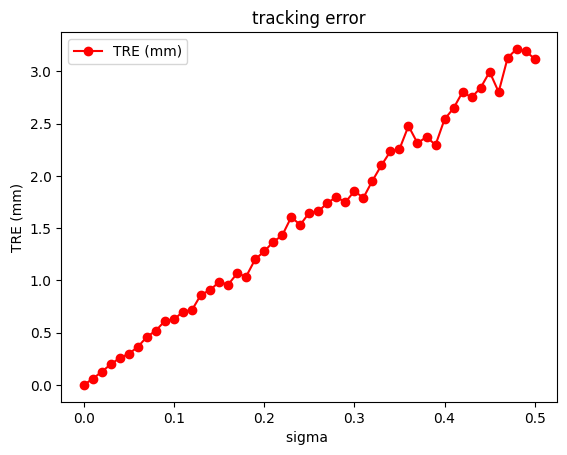

In [26]:
plot_TRE_results(tracking_x_values, tracking_y_values, title='tracking error')


## Experiment 2: Registration 

The total system accuracy will also be affected by the PatRef_T_MRI transformation. This is achieved using a point-based-registration (PBR), or an ICP surface-based-registration. However, ultimately, both produce a rigid matrix. If we decompose the PatRef_T_MRI matrix into individual rotations and translations, we can study the effect of registration error, as noise is added to these rotation and translation parameters.

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev.
* for sigma in 0 to 1, in steps of 0.01
*   for iteration in 1 to (number of samples).
*     add zero mean Gaussian (sigma) noise to each tracking marker for pnt ref and pat ref. 
*     add zero mean Gaussian (sigma) noise to each parameter of the PatRef_T_MRI transform
*     recompute transforms.
*     recompute position of pointer tip using noisy transforms
*     measure Euclidean distance in MRI space
* 
*   compute RMS error over each iteration
* produce graph of RMS (TRE) for each value of sigma
```

In [27]:
registration_x_values, registration_y_values \
    = simulation(PatRef_T_Cam=PatRef_T_Cam, 
                 Cam_T_PntRef=Cam_T_PntRef, 
                 PntRef_T_PntTip=PntRef_T_PntTip, 
                 MRI_T_PatRef=MRI_T_PatRef, 
                 
                 pnt_ref_marker=pnt_ref_marker, 
                 pnt_ref_cam=pnt_ref_cam,

                 pat_ref_marker=pat_ref_marker, 
                 pat_ref_cam=pat_ref_cam,

                 NUMBER_SAMPLES=NUMBER_SAMPLES,
                 END_SIGMA=END_SIGMA ,
                 SIGMA_STEP=SIGMA_STEP,  
                 
                 add_reg_error=True, # adding registration noise
                 add_tracking_noise=False, 
                 varying_length=False)

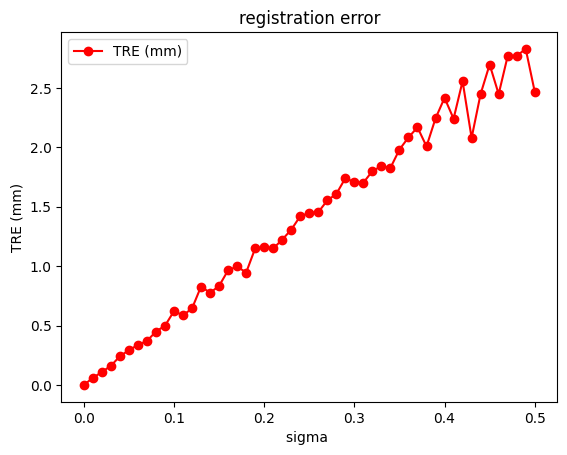

In [28]:
plot_TRE_results(registration_x_values, registration_y_values, title='registration error')


## Experiment 3: varying legnths

Here we change the length of the pointer to see what the corresponding target registration error (TRE) is with tracking noise.

The way this code is written, the pointer length is used to generate the test data. Also vendors provide a specific pointer. So, in practice we won't be responsible for designing a new pointer.

```python
* initialise some arrays to store accuracy data, so we can then compute mean/stddev and of sigma
* for sigma in [0.12, 0.15, 0.25, 0.5]
    * for pointer_length in 10 to 30, in steps of 5
    *   for iteration in 1 to (number of samples).
    *     compute transforms with the selected noise
    *     recompute position of pointer tip
    *     measure Euclidean distance in MRI space
    * 
    *   compute RMS error over each iteration
    * produce graph of RMS (TRE) for each value of sigma
```

pointer length: 100
[0.12 0.15 0.2  0.25 0.5 ] [0.77560491 0.92333442 1.22982665 1.71125412 3.03946728]
pointer length: 110
[0.12 0.15 0.2  0.25 0.5 ] [0.74230907 0.98359094 1.24297184 1.70169044 3.45871633]
pointer length: 120
[0.12 0.15 0.2  0.25 0.5 ] [0.75167796 0.90549945 1.28439689 1.68477284 3.12288564]
pointer length: 130
[0.12 0.15 0.2  0.25 0.5 ] [0.71071665 0.92066397 1.26576287 1.4903852  2.94144307]
pointer length: 140
[0.12 0.15 0.2  0.25 0.5 ] [0.72798679 0.93871744 1.33773024 1.61089403 3.44903641]
pointer length: 150
[0.12 0.15 0.2  0.25 0.5 ] [0.7335276  0.89383843 1.28597516 1.73977554 3.23896299]
pointer length: 160
[0.12 0.15 0.2  0.25 0.5 ] [0.75579031 0.96195606 1.22193803 1.59819831 3.02048204]
pointer length: 170
[0.12 0.15 0.2  0.25 0.5 ] [0.80225594 0.98515995 1.22570841 1.67596263 3.2756    ]
pointer length: 180
[0.12 0.15 0.2  0.25 0.5 ] [0.78434395 1.03642236 1.28694641 1.50083458 3.25740287]
pointer length: 190
[0.12 0.15 0.2  0.25 0.5 ] [0.76002512 0.978

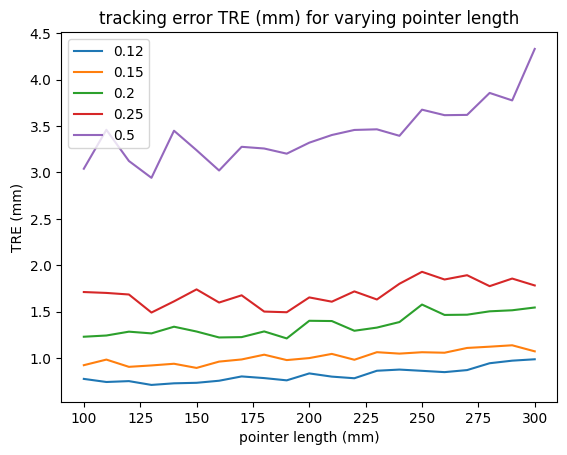

In [29]:
# TRACKER ERROR SIMULATION
# length_errors = []
varying_length_x_values = []
varying_length_y_values = []
test_pointer_lengths = np.arange(100, 301, 10)
for test_pointer_length in test_pointer_lengths:
    MRI_T_PatRef, PatRef_T_Cam, Cam_T_PntRef, PntRef_T_PntTip, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam = get_transforms(pointer_length=test_pointer_length, POINTER_ANGLE=POINTER_ANGLE,DISTANCE_FROM_CAM=DISTANCE_FROM_CAM, TUMOUR_PARTEF=TUMOUR_PARTEF)

    # tracking_error_12, tracking_error_15, tracking_error_25, tracking_error_20
    tracking_varying_length_x_values, tracking_varying_length_y_values \
          = simulation(PatRef_T_Cam=PatRef_T_Cam, 
                      Cam_T_PntRef=Cam_T_PntRef, 
                      PntRef_T_PntTip=PntRef_T_PntTip, 
                      MRI_T_PatRef=MRI_T_PatRef, 
                      
                      pnt_ref_marker=pnt_ref_marker, 
                      pnt_ref_cam=pnt_ref_cam,

                      pat_ref_marker=pat_ref_marker, 
                      pat_ref_cam=pat_ref_cam,

                      NUMBER_SAMPLES=NUMBER_SAMPLES,
                      END_SIGMA=END_SIGMA ,
                      SIGMA_STEP=SIGMA_STEP,  
                      
                      add_reg_error=False, 
                      add_tracking_noise=True, # adding tracking noise
                      varying_length=True)
    print(tracking_varying_length_x_values, tracking_varying_length_y_values)
    # if test_pointer_length == 100 or test_pointer_length == 150 or test_pointer_length == 250:
    #    length_errors.append([test_pointer_length, tracking_error_12, tracking_error_15,tracking_error_20, tracking_error_25])
    varying_length_x_values.append(tracking_varying_length_x_values)
    varying_length_y_values.append(tracking_varying_length_y_values)
sigmas = [0.12, 0.15, 0.2, 0.25, 0.5]
plt.plot(test_pointer_lengths, varying_length_y_values, label=sigmas)
plt.legend(loc='upper left')
plt.xlabel('pointer length (mm)')
plt.ylabel('TRE (mm)')
plt.title(f'tracking error TRE (mm) for varying pointer length')
plt.show()

# all errors together

In [30]:
pointer_length = 140

MRI_T_PatRef, PatRef_T_Cam, Cam_T_PntRef, PntRef_T_PntTip, pnt_ref_marker, \
      pnt_ref_cam, pat_ref_marker, pat_ref_cam = get_transforms(
          pointer_length=pointer_length, 
          POINTER_ANGLE=POINTER_ANGLE,
          DISTANCE_FROM_CAM=DISTANCE_FROM_CAM, 
          TUMOUR_PARTEF=TUMOUR_PARTEF)


total_x_values, total_y_values \
    = simulation(PatRef_T_Cam=PatRef_T_Cam, 
                 Cam_T_PntRef=Cam_T_PntRef, 
                 PntRef_T_PntTip=PntRef_T_PntTip, 
                 MRI_T_PatRef=MRI_T_PatRef, 
                 
                 pnt_ref_marker=pnt_ref_marker, 
                 pnt_ref_cam=pnt_ref_cam,

                 pat_ref_marker=pat_ref_marker, 
                 pat_ref_cam=pat_ref_cam,

                 NUMBER_SAMPLES=NUMBER_SAMPLES,
                 END_SIGMA=END_SIGMA ,
                 SIGMA_STEP=SIGMA_STEP,  
                 
                 add_reg_error=True, # adding registration noise
                 add_tracking_noise=True, 
                 varying_length=False)

pointer length: 140


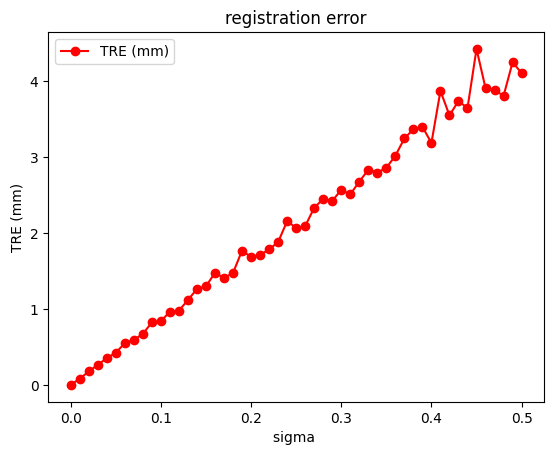

In [31]:
plot_TRE_results(total_x_values, total_y_values, title='registration error')


## results

In [32]:
header = ['group', 'error', 'sigma', 'unit', 'TRE']
data_pointer = [
        ['pointer', 'tracking', '0.20', 'mm', float(tracking_y_values[tracking_x_values == 0.2])],
        ['pointer', 'registration', '0.20', 'mm', float(registration_y_values[registration_x_values == 0.2])]
]

In [33]:
print('tracking error')
print(tracking_y_values[tracking_x_values == 0.2])

tracking error
[1.27791186]


In [34]:
print('registration error')
print(registration_y_values[registration_x_values == 0.2])

registration error
[1.15842276]


In [35]:
print('total error')
print(total_y_values[total_x_values == 0.2])

total error
[1.68187154]
